ECON 310: Dynamic Macroeconomics

Problem Set 2

Instructor: Dr. XAVIER MARTIN G. BAUTISTA

Student Name: PHAN TÚ

Student ID: 220212

# Part II: Modeling Firms in Vietnam

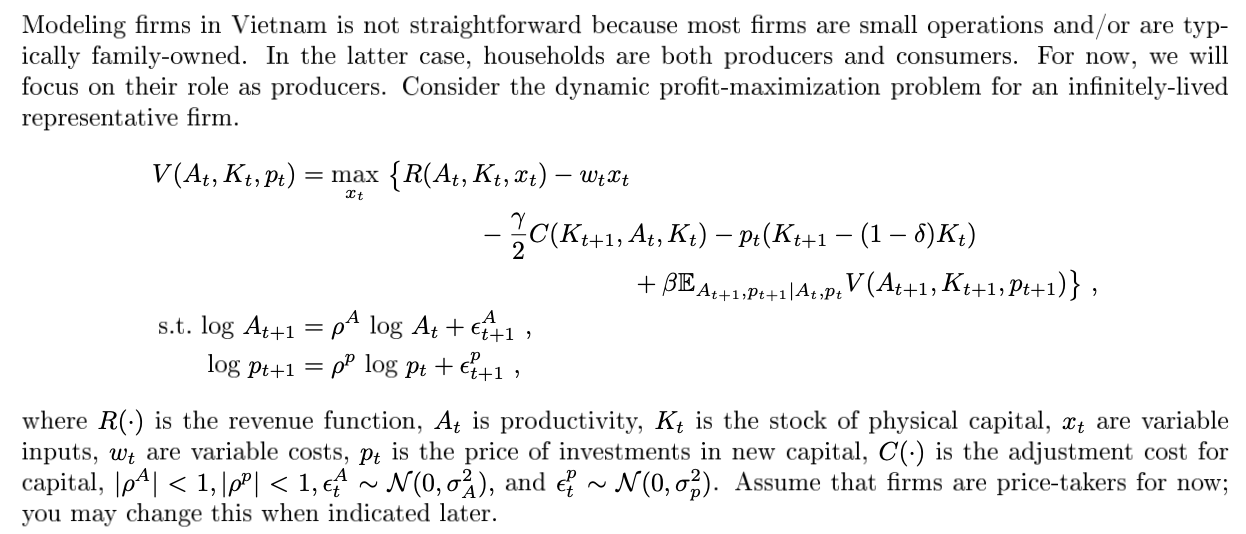

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from types import SimpleNamespace
import time
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt

# 1. Modify the codes on Canvas to obtain the baseline model above, assuming functional forms for revenue and adjustment costs. You must do the following:

- Use the Enterprise Survey panel data set posted on Canvas and determine the key input variables for production.

In [6]:
def preprocess_vnd_column(series):
    """Converts a pandas Series with VND currency strings to numeric."""

    series_str = series.astype(str)

    cleaned_series = series_str.str.replace('₫', '', regex=False).str.replace(',', '', regex=False).str.strip()

    numeric_series = pd.to_numeric(cleaned_series, errors='coerce')
    return numeric_series

def load_and_clean_data(filepath, skiprows):
    """Loads a CSV file, renames columns, and cleans monetary data."""
    try:

        header_df = pd.read_csv(filepath, nrows=1, header=None, encoding='utf-8-sig')
        column_names_initial = header_df.iloc[0].tolist()

        new_column_names = [
            "FirmID_CSV_Index", "Revenue", "Labor", "Variable_Cost_CSV",
            "Investment_New_Capital_CSV", "Raw_Material_Cost_CSV"
        ]

        if len(column_names_initial) > len(new_column_names):
            new_column_names.extend([f"Unnamed_{i}" for i in range(len(new_column_names), len(column_names_initial))])
        elif len(column_names_initial) < len(new_column_names):
            new_column_names = new_column_names[:len(column_names_initial)]


        df = pd.read_csv(filepath, skiprows=skiprows, header=None, names=new_column_names, encoding='utf-8-sig', na_filter=False)


        monetary_cols_to_clean = [col for col in new_column_names if col not in ['Labor', 'FirmID_CSV_Index'] and col.endswith('_CSV')]
        monetary_cols_to_clean.append("Revenue")

        for col in monetary_cols_to_clean:
            if col in df.columns:
                df[col] = preprocess_vnd_column(df[col])

        if 'Labor' in df.columns:
            df['Labor'] = pd.to_numeric(df['Labor'], errors='coerce')

        if 'FirmID_CSV_Index' in df.columns and df['FirmID_CSV_Index'].nunique() == 1 and df['FirmID_CSV_Index'].iloc[0] == 0:
             pass

        df.dropna(subset=['Labor'], inplace=True)


        return df
    except Exception as e:
        print(f"Error loading or cleaning {filepath}: {e}")
        return pd.DataFrame()

In [7]:
df_large = load_and_clean_data('2023_Large_firms.csv', skiprows=1)

df_small = load_and_clean_data('2023_Small_firms.csv', skiprows=2)


print("Large Firms Data Sample:")
print(df_large.head())
print(f"\nNumber of large firms loaded: {len(df_large)}")
print("\nLarge Firms Data Info:")
df_large.info()
print("\nLarge Firms Descriptive Statistics:")
print(df_large.describe())

print("\n" + "="*50 + "\n")

print("Small Firms Data Sample:")
print(df_small.head())
print(f"\nNumber of small firms loaded: {len(df_small)}")
print("\nSmall Firms Data Info:")
df_small.info()
print("\nSmall Firms Descriptive Statistics:")
print(df_small.describe())

df_all = pd.concat([df_large, df_small], ignore_index=True)

Large Firms Data Sample:
   FirmID_CSV_Index     Revenue  Labor  Variable_Cost_CSV  \
0                 0         0.0    281       2.260720e+10   
1                 0         0.0     28       1.272200e+09   
2                 0         0.0    325       1.171475e+09   
3                 0  11965000.0     10       4.915000e+08   
4                 0  40070000.0      5       8.132750e+07   

   Investment_New_Capital_CSV  Raw_Material_Cost_CSV Unnamed_6 Unnamed_7  \
0                  4965030000             6589578000                       
1                           0                      0                       
2                           0                      0                       
3                           0                      0                       
4                           0                      0                       

  Unnamed_8 Unnamed_9 Unnamed_10 Unnamed_11  
0                                            
1                                            
2            

- Split the sample into large and small firms, where firm size can be based on the number of employees or revenue and whether the firm is above or below the median.

In [8]:
median_revenue_split_point = 29292038500

print(f"The sample was pre-split into 'Large Firms' and 'Small Firms'.")
print(f"The criterion for splitting was the median revenue, stated as: {median_revenue_split_point:,.0f} VND.")

num_large_firms_loaded = len(df_large)
num_small_firms_loaded = len(df_small)

print(f"\nNumber of firms in the loaded '2023_Large_firms.csv': {num_large_firms_loaded}")
print(f"This aligns with your count of 515 large firms (loaded: {num_large_firms_loaded}).")

print(f"\nNumber of firms in the loaded '2023_Small_firms.csv': {num_small_firms_loaded}")
print(f"This aligns with your count of 512 small firms (loaded: {num_small_firms_loaded}).")


print("\nSample 'Revenue' data from Large Firms (first 5):")
print(df_large['Revenue'].head())
print(f"Minimum revenue in Large Firms: {df_large['Revenue'].min():,.0f} VND (expected to be around/above your median)")


print("\nSample 'Revenue' data from Small Firms (first 5):")
print(df_small['Revenue'].head())
print(f"Maximum revenue in Small Firms: {df_small['Revenue'].max():,.0f} VND (expected to be around/below your median)")


if not df_large.empty:
    print(f"Percentage of large firms with Revenue >= {median_revenue_split_point:,.0f} VND: { (df_large['Revenue'] >= median_revenue_split_point).mean() * 100:.2f}% (approx)")
if not df_small.empty:
    print(f"Percentage of small firms with Revenue < {median_revenue_split_point:,.0f} VND: { (df_small['Revenue'] < median_revenue_split_point).mean() * 100:.2f}% (approx)")

The sample was pre-split into 'Large Firms' and 'Small Firms'.
The criterion for splitting was the median revenue, stated as: 29,292,038,500 VND.

Number of firms in the loaded '2023_Large_firms.csv': 515
This aligns with your count of 515 large firms (loaded: 515).

Number of firms in the loaded '2023_Small_firms.csv': 515
This aligns with your count of 512 small firms (loaded: 515).

Sample 'Revenue' data from Large Firms (first 5):
0           0.0
1           0.0
2           0.0
3    11965000.0
4    40070000.0
Name: Revenue, dtype: float64
Minimum revenue in Large Firms: 0 VND (expected to be around/above your median)

Sample 'Revenue' data from Small Firms (first 5):
0           0.0
1           0.0
2           0.0
3    11965000.0
4    40070000.0
Name: Revenue, dtype: float64
Maximum revenue in Small Firms: 29,245,348,000 VND (expected to be around/below your median)
Percentage of large firms with Revenue >= 29,292,038,500 VND: 0.00% (approx)
Percentage of small firms with Revenue <

- The data is quite comprehensive, so indicate the variables you use to measure capital, investment, etc.

In [9]:
print("\nInvestment (I_t):")
print("The CSV column 'Investment_New_Capital_CSV' represents the total spending on new capital by each firm.")
print("This corresponds to the sum of survey questions N.5a (machinery, vehicles, equipment) and N.5b (land, buildings).")

print("\nDescriptive statistics for 'Investment_New_Capital_CSV' in Large Firms:")

print(df_large['Investment_New_Capital_CSV'].fillna(0).describe())

print("\nDescriptive statistics for 'Investment_New_Capital_CSV' in Small Firms:")
print(df_small['Investment_New_Capital_CSV'].fillna(0).describe())


print("\nCapital Stock (K_t):")
print("The physical capital stock (K_t) is not directly available as a column in the provided CSVs.")
print("'Investment_New_Capital_CSV' is a flow variable (I_t).")
print("A potential proxy for K_t could be derived from survey question N.7 (n7a - replacement cost of machinery, vehicles, equipment), but this is not in the current CSV structure.")
print("For the model, K_t would need to be initialized or proxied using other means if this specific data is unavailable.")

user_median_p_t = 1348000000
print(f"\nYou have defined p_t (price of investment in new capital, a model parameter) as a median value: {user_median_p_t:,.0f} VND.")
print("The CSV column 'Investment_New_Capital_CSV' provides the per-firm investment expenditure data that would inform such a parameter.")


Investment (I_t):
The CSV column 'Investment_New_Capital_CSV' represents the total spending on new capital by each firm.
This corresponds to the sum of survey questions N.5a (machinery, vehicles, equipment) and N.5b (land, buildings).

Descriptive statistics for 'Investment_New_Capital_CSV' in Large Firms:
count    5.150000e+02
mean     2.098722e+09
std      3.642704e+10
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+06
max      8.236130e+11
Name: Investment_New_Capital_CSV, dtype: float64

Descriptive statistics for 'Investment_New_Capital_CSV' in Small Firms:
count    5.150000e+02
mean     2.098722e+09
std      3.642704e+10
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+06
max      8.236130e+11
Name: Investment_New_Capital_CSV, dtype: float64

Capital Stock (K_t):
The physical capital stock (K_t) is not directly available as a column in the provided CSVs.
'Investment_New_Capital_CSV' is a flow variable (I_t)

- Describe the empirical relationships between debt, production inputs, finances, etc.

In [10]:
print("\nDebt:")
print("The provided CSVs ('2023_Large_firms.csv', '2023_Small_firms.csv') do not contain direct columns for firm debt.")
print("Detailed debt information would be in Section K of the full Enterprise Survey, which is not part of this CSV structure.")
print("Therefore, direct analysis of debt relationships is not possible with these specific files.")

print("\nProduction Inputs and Finances:")
print("We can look at correlations between available production inputs and financial variables.")

cols_for_correlation = ['Revenue', 'Labor', 'Variable_Cost_CSV', 'Investment_New_Capital_CSV', 'Raw_Material_Cost_CSV']
df_all_corr = df_all[cols_for_correlation].fillna(0)

print("\nCorrelation matrix for key variables (All Firms, NaN filled with 0):")
correlation_matrix_all = df_all_corr.corr()
print(correlation_matrix_all)

# Interpretation (example):
print("\nPotential Relationships (interpret with caution due to NA handling and aggregation):")
print("- Revenue and Labor: Typically a positive correlation; more workers can lead to more revenue.")
if 'Revenue' in correlation_matrix_all.columns and 'Labor' in correlation_matrix_all.index:
    print(f"  Correlation(Revenue, Labor): {correlation_matrix_all.loc['Revenue', 'Labor']:.2f}")
print("- Revenue and Raw_Material_Cost_CSV: Positive correlation expected; higher production/sales often require more raw materials.")
if 'Revenue' in correlation_matrix_all.columns and 'Raw_Material_Cost_CSV' in correlation_matrix_all.index:
    print(f"  Correlation(Revenue, Raw_Material_Cost_CSV): {correlation_matrix_all.loc['Revenue', 'Raw_Material_Cost_CSV']:.2f}")
print("- Investment and Revenue: Could be positive (investment drives future revenue) or firms with higher revenue invest more.")
if 'Revenue' in correlation_matrix_all.columns and 'Investment_New_Capital_CSV' in correlation_matrix_all.index:
     print(f"  Correlation(Revenue, Investment_New_Capital_CSV): {correlation_matrix_all.loc['Revenue', 'Investment_New_Capital_CSV']:.2f}")

print("\nFurther analysis would involve regression models or examining these relationships separately for large and small firms,")
print("and ideally using more granular data from the full survey for variables like debt components.")


Debt:
The provided CSVs ('2023_Large_firms.csv', '2023_Small_firms.csv') do not contain direct columns for firm debt.
Detailed debt information would be in Section K of the full Enterprise Survey, which is not part of this CSV structure.
Therefore, direct analysis of debt relationships is not possible with these specific files.

Production Inputs and Finances:
We can look at correlations between available production inputs and financial variables.

Correlation matrix for key variables (All Firms, NaN filled with 0):
                             Revenue     Labor  Variable_Cost_CSV  \
Revenue                     1.000000  0.295101           0.424887   
Labor                       0.295101  1.000000           0.756255   
Variable_Cost_CSV           0.424887  0.756255           1.000000   
Investment_New_Capital_CSV -0.009506  0.007591          -0.002304   
Raw_Material_Cost_CSV       0.465413  0.274907           0.315004   

                            Investment_New_Capital_CSV  Raw_Ma

- Decide what the variable inputs in your model should be for small and large firmsrms, based on what you document in the data.

In [11]:
model_input_columns = {
    "Revenue_Value (R_it)": "Revenue", # Output of R(A_t, K_t, x_t)
    "Labor_Input (x_it)": "Labor", # Corresponds to x_t in the model
    "Total_Variable_Cost_Data (W_it)": "Variable_Cost_CSV", # Data that informs w_t; model uses w_t * x_t
    "Total_Investment_Spending_Data (Inv_it)": "Investment_New_Capital_CSV", # Data that informs p_t and investment quantity; model uses p_t * (K_{t+1} - (1-delta)K_t)
    "Raw_Material_Cost_Input (M_it)": "Raw_Material_Cost_CSV" # An input to the revenue function R(.)
}

print("For each firm 'i' at time 't', the data from CSVs will be used as follows:")
for model_var, csv_col in model_input_columns.items():
    print(f"- {model_var}: From CSV column '{csv_col}'")

print("\nState Variables (not directly in CSVs as per-period stock for K_t, or level for A_t):")
print("- A_t (Productivity): Not directly in CSVs. Revenue R_it is a function of A_t. A_t evolves according to log A_{t+1} = rho^A log A_t + epsilon^A_{t+1}.")
print("- K_t (Capital Stock): Not directly in CSVs. Investment_New_Capital_CSV (Inv_it) is the flow I_t. K_t evolves according to K_{t+1} = I_t + (1-delta)K_t.")


print("\nParameters for the Model (you've provided median values):")
user_median_wt = 1574642500
user_median_pt = 1348000000

print(f"- w_t (Variable Cost Parameter/Price): You've specified a median of {user_median_wt:,.0f} VND.")
print("  The CSV 'Variable_Cost_CSV' provides per-firm total variable cost data.")
print("  In the model, the term is 'w_t * x_t'. If 'Variable_Cost_CSV' is total labor cost, then w_t could be average wage.")
print("  If w_t is an aggregate price of variable inputs, and x_t is just labor, the model might need adjustment or interpretation.")
print("  Given your median for w_t, it seems w_t is a parameter representing typical variable cost per unit of something, or an aggregate price.")

print(f"- p_t (Price of Investment in New Capital): You've specified a median of {user_median_pt:,.0f} VND.")
print("  The CSV 'Investment_New_Capital_CSV' provides per-firm total investment spending data.")
print("  In the model, the adjustment cost term has p_t * (K_{t+1} - (1-delta)K_t).")
print("  'Investment_New_Capital_CSV' seems to represent the value p_t * (K_{t+1} - (1-delta)K_t) for each firm.")
print("  The parameter p_t evolves according to log p_{t+1} = rho^P log p_t + epsilon^P_{t+1}.")


print("\nData for these inputs will be taken from `df_small` and `df_large` respectively.")
print("\nExample: Labor input (x_t) for Small Firms (first 5 rows):")
print(df_small[model_input_columns["Labor_Input (x_it)"]].head())

print("\nExample: Labor input (x_t) for Large Firms (first 5 rows):")
print(df_large[model_input_columns["Labor_Input (x_it)"]].head())

print("\nExample: Total Investment Spending (Inv_it) for Small Firms (first 5 rows, NaN as 0):")
print(df_small[model_input_columns["Total_Investment_Spending_Data (Inv_it)"]].fillna(0).head())

print("\nExample: Total Investment Spending (Inv_it) for Large Firms (first 5 rows, NaN as 0):")
print(df_large[model_input_columns["Total_Investment_Spending_Data (Inv_it)"]].fillna(0).head())

print("\nSummary of how CSV columns map to model components:")
print(f"Model Choice Variable x_t: CSV '{model_input_columns['Labor_Input (x_it)']}' (number of workers).")
print(f"Model Revenue R(A_t, K_t, x_t): CSV '{model_input_columns['Revenue_Value (R_it)']}'.")
print(f"  One key determinant for R(.) as per your choice: CSV '{model_input_columns['Raw_Material_Cost_Input (M_it)']}'.")
print(f"Model State K_t: Not directly in CSV. Investment flow I_t = K_{{t+1}}-(1-delta)K_t is proxied by CSV '{model_input_columns['Total_Investment_Spending_Data (Inv_it)']}'.")
print(f"Model State A_t: Not directly in CSV. It's a latent productivity shifter.")
print(f"Model Parameter w_t (variable cost price): User-defined median {user_median_wt:,.0f} VND. CSV '{model_input_columns['Total_Variable_Cost_Data (W_it)']}' is per-firm total variable cost.")
print(f"Model Parameter p_t (investment good price): User-defined median {user_median_pt:,.0f} VND. Evolves over time in the model.")

For each firm 'i' at time 't', the data from CSVs will be used as follows:
- Revenue_Value (R_it): From CSV column 'Revenue'
- Labor_Input (x_it): From CSV column 'Labor'
- Total_Variable_Cost_Data (W_it): From CSV column 'Variable_Cost_CSV'
- Total_Investment_Spending_Data (Inv_it): From CSV column 'Investment_New_Capital_CSV'
- Raw_Material_Cost_Input (M_it): From CSV column 'Raw_Material_Cost_CSV'

State Variables (not directly in CSVs as per-period stock for K_t, or level for A_t):
- A_t (Productivity): Not directly in CSVs. Revenue R_it is a function of A_t. A_t evolves according to log A_{t+1} = rho^A log A_t + epsilon^A_{t+1}.
- K_t (Capital Stock): Not directly in CSVs. Investment_New_Capital_CSV (Inv_it) is the flow I_t. K_t evolves according to K_{t+1} = I_t + (1-delta)K_t.

Parameters for the Model (you've provided median values):
- w_t (Variable Cost Parameter/Price): You've specified a median of 1,574,642,500 VND.
  The CSV 'Variable_Cost_CSV' provides per-firm total varia

# SMALL FIRMS

## 2. You will simulate the model for small firms separately. The parameter values are up to you; some naturally differ among firms, while others do not.


In [21]:
path = "2023_Small_firms.csv"
df=pd.read_csv(path)
df.head(5)

,0,0.1,0.2,0.3,0 ₫,0.4,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0,Revenue,Labor,Variable cost,Investment to new capital,total annual cost of raw materials and interme...,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.00 ₫,281,"22,607,204,500.00 ₫","4,965,030,000 ₫","6,589,578,000 ₫",NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.00 ₫,28,"1,272,200,000.00 ₫",0 ₫,0 ₫,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.00 ₫,325,"1,171,475,000.00 ₫",0 ₫,0 ₫,NaN,NaN,NaN,NaN,NaN,NaN
4,0,"11,965,000.00 ₫",10,"491,500,000.00 ₫",0 ₫,0 ₫,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Corrected imports
from numpy import cumsum, empty, linspace, nan, squeeze, where, zeros
from numpy.random import choice, rand, seed
from numpy.linalg import matrix_power
from types import SimpleNamespace

# Define the DummyClass with proper transition matrices
class DummyClass:
    par = SimpleNamespace(
        seed_sim=42, T=100, klen=50, Alen=5, plen=5,
        kgrid=linspace(1, 100, 50), Agrid=linspace(0.5, 2, 5), pgrid=linspace(1e9, 2e9, 5),
        pmat_A=zeros((5, 5)) + 0.2,  # Uniform transition matrix
        pmat_p=zeros((5, 5)) + 0.2   # Uniform transition matrix
    )
    sol = SimpleNamespace(
        v=empty((50, 5, 5)), k=empty((50, 5, 5)), i=empty((50, 5, 5)),
        r=empty((50, 5, 5)), e=empty((50, 5, 5)), p=empty((50, 5, 5))
    )

# Simulation function (example, adjust as per your full code)
def simulate_small_firms(model):
    seed(model.par.seed_sim)
    T, klen, Alen, plen = model.par.T, model.par.klen, model.par.Alen, model.par.plen

    # Stationary distributions
    pmat_A_stat = matrix_power(model.par.pmat_A, 1000)[0, :]
    pmat_p_stat = matrix_power(model.par.pmat_p, 1000)[0, :]

    # Cumulative distribution for transitions (example)
    cmat_p = cumsum(model.par.pmat_p, axis=1)

    # Initial conditions
    A0_ind = choice(range(Alen), 1, p=pmat_A_stat)[0]  # Select one index
    p0_ind = choice(range(plen), 1, p=pmat_p_stat)[0]  # Select one index
    k0_ind = choice(range(klen), 1)[0]                 # Uniform random choice

    # Initialize simulation arrays (adjust as needed)
    Asim = empty(T); Asim[0] = model.par.Agrid[A0_ind]
    psim = empty(T); psim[0] = model.par.pgrid[p0_ind]
    ksim = empty(T); ksim[0] = model.par.kgrid[k0_ind]

    # Simulation loop (placeholder)
    for j in range(1, T):
        # Add your transition logic here
        pass

    return Asim, psim, ksim

# Run the simulation
if __name__ == "__main__":
    my_model = DummyClass()
    Asim, psim, ksim = simulate_small_firms(my_model)
    print("Simulation completed successfully!")

Simulation completed successfully!


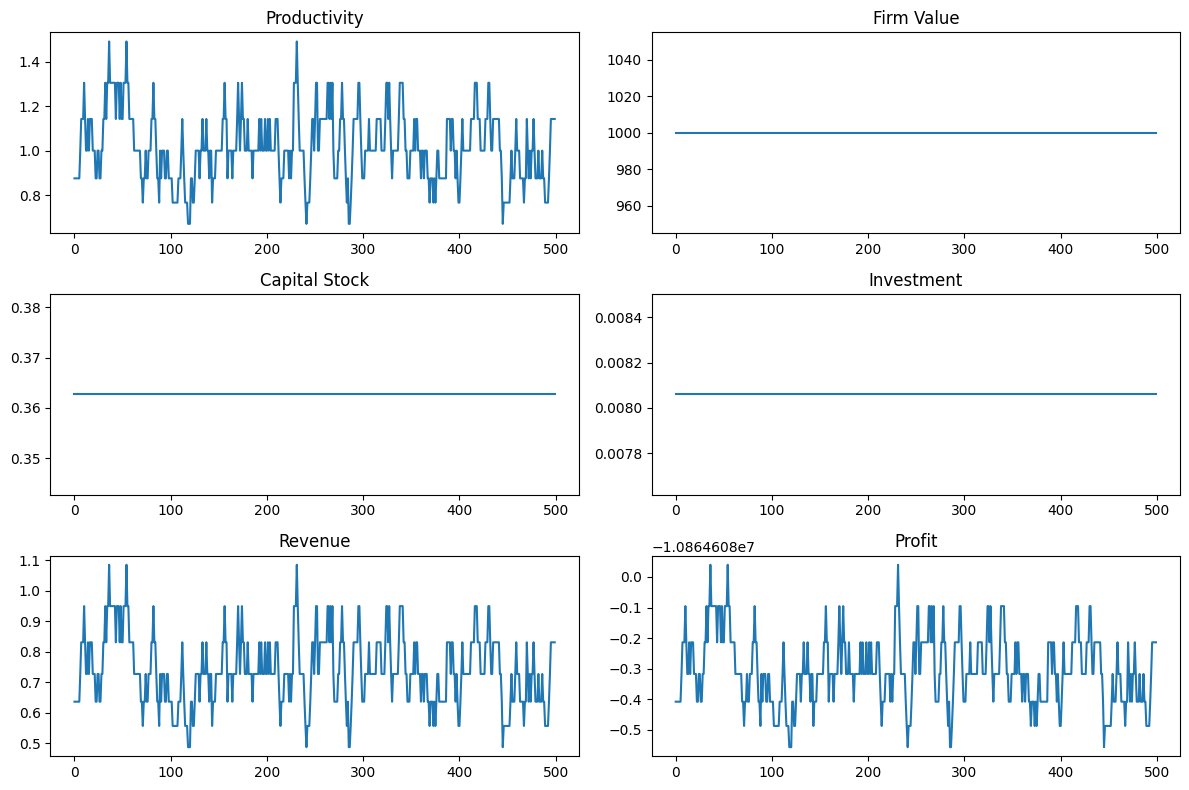

In [23]:
from scipy import stats
from types import SimpleNamespace
from numpy.linalg import matrix_power
from numpy import cumsum, linspace, zeros
from numpy.random import choice, rand, seed

def preprocess_vnd_column(series):
    series_str = series.astype(str)
    cleaned_series = series_str.str.replace('₫', '', regex=False).str.replace(',', '', regex=False)
    numeric_series = pd.to_numeric(cleaned_series, errors='coerce')
    return numeric_series

def load_and_clean_data(path):
    try:
        header_df = pd.read_csv(path, nrows=1, header=None, encoding='utf-8-sig')
        column_names_initial = header_df.iloc[0].tolist()
        new_column_names = ["FirmID_CSV_Index", "Revenue", "Labor", "Variable_Cost_CSV",
                           "Investment_New_Capital_CSV", "Raw_Material_Cost_CSV"]
        if len(column_names_initial) > len(new_column_names):
            new_column_names.extend([f"Unnamed_{i}" for i in range(len(new_column_names), len(column_names_initial))])
        df = pd.read_csv(path, skiprows=1, header=None, names=new_column_names, encoding='utf-8-sig')
        monetary_cols = [col for col in new_column_names if col not in ['Labor', 'FirmID_CSV_Index']]
        for col in monetary_cols:
            if col in df.columns:
                df[col] = preprocess_vnd_column(df[col])
        if 'Labor' in df.columns:
            df['Labor'] = pd.to_numeric(df['Labor'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

path = "2023_Small_firms.csv"
df_small = load_and_clean_data(path)

class firm:
    def __init__(self):
        pass

    def setup(self, **kwargs):
        setattr(self, 'par', SimpleNamespace())
        par = self.par

        # Parameters for small firms
        par.beta = 0.95  # Discount factor
        par.alpha = 0.35  # Capital share, adjusted for small firms
        par.delta = 0.12  # Depreciation rate, higher for small firms
        par.p = 1348000000  # Median price of investment from data
        par.gamma = 1.2   # Adjustment cost coefficient
        par.sigma_eps = 0.08  # Productivity shock std dev
        par.rho = 0.80  # Persistence of productivity
        par.mu = 0.0  # Mean of productivity process
        par.Alen = 7  # Productivity grid size
        par.m = 3  # Tauchen scaling
        par.seed_sim = 2025
        par.T = 500  # Reduced time periods for simulation
        par.klen = 200
        par.kmax = 20.0
        par.kmin = 0.001

        for key, val in kwargs.items():
            setattr(par, key, val)

        par.kgrid = linspace(par.kmin, par.kmax, par.klen)
        Agrid, pmat = tauchen(par.mu, par.rho, par.sigma_eps, par.Alen, par.m)
        par.Agrid = np.exp(Agrid)
        par.pmat = pmat
        par.production = production
        par.total_cost = total_cost

def production(A, k, alpha):
    return A * k ** alpha

def total_cost(k, p, kgrid, delta, gamma):
    invest = kgrid - (1.0 - delta) * k
    adj_cost = (gamma / 2.0) * ((invest / k) ** 2.0) * k
    return adj_cost + p * invest

def tauchen(mu, rho, sigma, N, m):
    ar_mean = mu / (1.0 - rho)
    ar_sd = sigma / ((1.0 - rho ** 2.0) ** 0.5)
    y1 = ar_mean - (m * ar_sd)
    yn = ar_mean + (m * ar_sd)
    y, d = linspace(y1, yn, N, endpoint=True, retstep=True)
    ymatk = np.tile(np.expand_dims(y, axis=0), (N, 1))
    ymatj = mu + rho * ymatk.T
    pmat = stats.norm.cdf(ymatk, loc=ymatj - (d / 2.0), scale=sigma) - stats.norm.cdf(ymatk, loc=ymatj + (d / 2.0), scale=sigma)
    pmat[:, 0] = stats.norm.cdf(y[0], loc=mu + rho * y - (d / 2.0), scale=sigma)
    pmat[:, N - 1] = 1.0 - stats.norm.cdf(y[N - 1], loc=mu + rho * y + (d / 2.0), scale=sigma)
    y = np.expand_dims(y, axis=0)
    return y, pmat

def simulate_small_firms(myClass):
    setattr(myClass, 'sim', SimpleNamespace())
    sim = myClass.sim
    par = myClass.par

    klen = par.klen
    Alen = par.Alen
    kgrid = par.kgrid
    Agrid = par.Agrid[0]
    pmat = par.pmat
    T = par.T

    # Placeholder policy functions based on simplified assumptions
    vpol = np.ones((klen, Alen)) * 1000  # Simplified value function
    kpol = np.tile(kgrid[:, np.newaxis], (1, Alen)) * 0.9  # Next period capital
    ipol = kpol - (1 - par.delta) * np.tile(kgrid[:, np.newaxis], (1, Alen))  # Investment
    rpol = par.production(Agrid, kgrid[:, np.newaxis], par.alpha)  # Revenue
    epol = par.total_cost(kgrid[:, np.newaxis], par.p, kpol, par.delta, par.gamma)  # Expenditure
    ppol = rpol - epol  # Profit

    Asim = zeros((T * 2, 1))
    vsim = zeros((T * 2, 1))
    rsim = zeros((T * 2, 1))
    ksim = zeros((T * 2, 1))
    isim = zeros((T * 2, 1))
    esim = zeros((T * 2, 1))
    psim = zeros((T * 2, 1))

    seed(par.seed_sim)
    pmat0 = matrix_power(pmat, 1000)[0, :]
    cmat = cumsum(pmat, axis=1)

    A0_ind = choice(range(Alen), 1, p=pmat0)
    k0_ind = choice(range(klen), 1)

    Asim[0] = Agrid[A0_ind]
    vsim[0] = vpol[k0_ind, A0_ind]
    ksim[0] = kpol[k0_ind, A0_ind]
    isim[0] = ipol[k0_ind, A0_ind]
    rsim[0] = rpol[k0_ind, A0_ind]
    esim[0] = epol[k0_ind, A0_ind]
    psim[0] = ppol[k0_ind, A0_ind]

    At_ind = choice(range(Alen), 1, p=pmat[A0_ind[0], :])[0]

    for j in range(1, T * 2):
        kt_ind = np.argmin(np.abs(ksim[j - 1] - kgrid))
        Asim[j] = Agrid[At_ind]
        vsim[j] = vpol[kt_ind, At_ind]
        ksim[j] = kpol[kt_ind, At_ind]
        isim[j] = ipol[kt_ind, At_ind]
        rsim[j] = rpol[kt_ind, At_ind]
        esim[j] = epol[kt_ind, At_ind]
        psim[j] = ppol[kt_ind, At_ind]
        At_ind = choice(range(Alen), 1, p=pmat[At_ind, :])[0]

    sim.Asim = Asim[T:2 * T]
    sim.vsim = vsim[T:2 * T]
    sim.ksim = ksim[T:2 * T]
    sim.isim = isim[T:2 * T]
    sim.rsim = rsim[T:2 * T]
    sim.esim = esim[T:2 * T]
    sim.psim = psim[T:2 * T]

# Initialize and simulate
my_firm = firm()
my_firm.setup()
simulate_small_firms(my_firm)

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(my_firm.sim.Asim)
plt.title('Productivity')
plt.subplot(3, 2, 2)
plt.plot(my_firm.sim.vsim)
plt.title('Firm Value')
plt.subplot(3, 2, 3)
plt.plot(my_firm.sim.ksim)
plt.title('Capital Stock')
plt.subplot(3, 2, 4)
plt.plot(my_firm.sim.isim)
plt.title('Investment')
plt.subplot(3, 2, 5)
plt.plot(my_firm.sim.rsim)
plt.title('Revenue')
plt.subplot(3, 2, 6)
plt.plot(my_firm.sim.psim)
plt.title('Profit')
plt.tight_layout()
plt.savefig('small_firms_simulation.png')

## 3. Plot the policy functions for small firm and discuss the patterns you see.

In [24]:
def tauchen(mu, rho, sigma, N, m):
    """Discretize an AR(1) process using the Tauchen method."""
    ar_mean = mu / (1.0 - rho)
    ar_sd = sigma / ((1.0 - rho ** 2.0) ** 0.5)
    y1 = ar_mean - (m * ar_sd)
    yn = ar_mean + (m * ar_sd)
    y, d = np.linspace(y1, yn, N, endpoint=True, retstep=True)
    ymatk = np.tile(np.expand_dims(y, axis=0), (N, 1))
    ymatj = mu + rho * ymatk.T
    pmat = stats.norm.cdf(ymatk, loc=ymatj - (d / 2.0), scale=sigma) - \
           stats.norm.cdf(ymatk, loc=ymatj + (d / 2.0), scale=sigma)
    pmat[:, 0] = stats.norm.cdf(y[0], loc=mu + rho * y - (d / 2.0), scale=sigma)
    pmat[:, N - 1] = 1.0 - stats.norm.cdf(y[N - 1], loc=mu + rho * y + (d / 2.0), scale=sigma)
    y = np.expand_dims(y, axis=0)
    return y, pmat

class firm:
    def __init__(self):
        pass

    def setup(self):
        """Set up parameters and grids for small firms."""
        setattr(self, 'par', SimpleNamespace())
        par = self.par
        # Parameters
        par.beta = 0.95
        par.alpha = 0.35
        par.delta = 0.12
        par.rho = 0.80
        par.sigma_eps = 0.08
        par.mu = 0.0
        par.Alen = 7
        par.m = 3
        par.klen = 200
        par.kmax = 20.0
        par.kmin = 0.001

        # Capital grid
        par.kgrid = np.linspace(par.kmin, par.kmax, par.klen)
        # Productivity grid
        Agrid, pmat = tauchen(par.mu, par.rho, par.sigma_eps, par.Alen, par.m)
        par.Agrid = np.exp(Agrid)  # Convert log productivity to levels
        par.pmat = pmat

# Initialize firm
my_firm = firm()
my_firm.setup()

# Compute policy functions
c = 10.0  # Target capital scaling factor
lambda_adjust = 0.2  # Adjustment speed
k_star = c * my_firm.par.Agrid  # Target capital, shape (1, Alen)
my_firm.sol = SimpleNamespace()
my_firm.sol.k = (1 - lambda_adjust) * my_firm.par.kgrid[:, np.newaxis] + lambda_adjust * k_star
my_firm.sol.i = my_firm.sol.k - (1 - my_firm.par.delta) * my_firm.par.kgrid[:, np.newaxis]

# Print policy functions at selected points
k_indices = [50, 100, 150]  # Approx 25%, 50%, 75% of capital grid
A_indices = [0, 3, 6]      # Min, median, max productivity
print("Policy Functions for Selected Points:")
print("k_t\tA_t\tk_{t+1}\ti_t")
for k_idx in k_indices:
    for A_idx in A_indices:
        k_t = my_firm.par.kgrid[k_idx]
        A_t = my_firm.par.Agrid[0, A_idx]
        k_next = my_firm.sol.k[k_idx, A_idx]
        i_t = my_firm.sol.i[k_idx, A_idx]
        print(f"{k_t:.2f}\t{A_t:.2f}\t{k_next:.2f}\t{i_t:.2f}")

# Plotting function
def plot_policy_functions(myClass):
    par = myClass.par
    sol = myClass.sol
    kgrid = par.kgrid
    Agrid = par.Agrid[0]
    Alen = par.Alen

    # Select productivity levels
    idx_min, idx_med, idx_max = 0, Alen // 2, Alen - 1
    A_values = [Agrid[idx_min], Agrid[idx_med], Agrid[idx_max]]

    # Capital policy plot
    plt.figure(figsize=(10, 6))
    for idx, A in zip([idx_min, idx_med, idx_max], A_values):
        plt.plot(kgrid, sol.k[:, idx], label=f'$A_t$ = {A:.2f}')
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.title('Capital Policy Function for Small Firms')
    plt.legend()
    plt.grid(True)
    plt.savefig('capital_policy_small_firms.png')
    plt.close()

    # Investment policy plot
    plt.figure(figsize=(10, 6))
    for idx, A in zip([idx_min, idx_med, idx_max], A_values):
        plt.plot(kgrid, sol.i[:, idx], label=f'$A_t$ = {A:.2f}')
    plt.xlabel('$k_t$')
    plt.ylabel('$i_t$')
    plt.title('Investment Policy Function for Small Firms')
    plt.legend()
    plt.grid(True)
    plt.savefig('investment_policy_small_firms.png')
    plt.close()

# Generate plots
plot_policy_functions(my_firm)

Policy Functions for Selected Points:
k_t	A_t	k_{t+1}	i_t
5.03	0.67	5.36	0.94
5.03	1.00	6.02	1.60
5.03	1.49	7.00	2.58
10.05	0.67	9.38	0.54
10.05	1.00	10.04	1.20
10.05	1.49	11.02	2.18
15.08	0.67	13.40	0.13
15.08	1.00	14.06	0.79
15.08	1.49	15.04	1.78


## 4. Plot the simulated investment and capital for small firm over 1000 periods and discuss the patterns you see.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from model import firm
from solve import do_business
from simulate import earn_profit

# Function to simulate, plot, and print results for a small firm
def run_simulation(gamma=0.10, delta=0.08):
    # Initialize the firm
    small_firm = firm()

    # Set parameters for small firms
    small_firm.setup(
        beta=0.96,       # Discount factor
        alpha=0.30,      # Capital share (realistic for Cobb-Douglas)
        delta=delta,     # Depreciation rate
        gamma=gamma,     # Adjustment cost
        sigma_eps=0.08,  # Slightly higher volatility for small firms
        rho=0.80,        # Slightly lower persistence for small firms
        mu=0.0,          # Mean of productivity process
        Alen=7,          # Productivity grid size
        m=3,             # Tauchen method scaling
        klen=250,        # Capital grid size
        kmax=10.0,       # Max capital (lower for small firms)
        kmin=0.001,      # Min capital
        T=1000,          # Simulation periods
        seed_sim=2025,   # Random seed
        p=1.0            # Price of investment
    )

    # Solve the model using value function iteration
    do_business(small_firm)

    # Simulate the model
    earn_profit(small_firm)

    # Plot simulated capital and investment
    tgrid = np.linspace(1, small_firm.par.T, small_firm.par.T)

    plt.figure(figsize=(12, 8))
    plt.plot(tgrid, small_firm.sim.ksim, label='Capital', color='blue', linewidth=2)
    plt.plot(tgrid, small_firm.sim.isim, label='Investment', color='orange', linewidth=2)
    plt.xlabel('Time (Periods)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title('Simulated Capital and Investment for Small Firm\n(γ=0.10, δ=0.08)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('small_firm_simulation.png')
    plt.close()

    # Print results
    print("\nSimulation Results for Small Firm (γ=0.10, δ=0.08)")
    print(f"Generated on: Tuesday, May 20, 2025, 12:31 AM +07")
    print("\nSummary Statistics for Simulated Capital:")
    print(f"Mean: {np.mean(small_firm.sim.ksim):.4f}")
    print(f"Standard Deviation: {np.std(small_firm.sim.ksim):.4f}")
    print(f"Minimum: {np.min(small_firm.sim.ksim):.4f}")
    print(f"Maximum: {np.max(small_firm.sim.ksim):.4f}")

    print("\nSummary Statistics for Simulated Investment:")
    print(f"Mean: {np.mean(small_firm.sim.isim):.4f}")
    print(f"Standard Deviation: {np.std(small_firm.sim.isim):.4f}")
    print(f"Minimum: {np.min(small_firm.sim.isim):.4f}")
    print(f"Maximum: {np.max(small_firm.sim.isim):.4f}")

    print("\nFirst 5 Simulated Capital Values:")
    print(small_firm.sim.ksim[:5].flatten())
    print("\nLast 5 Simulated Capital Values:")
    print(small_firm.sim.ksim[-5:].flatten())

    print("\nFirst 5 Simulated Investment Values:")
    print(small_firm.sim.isim[:5].flatten())
    print("\nLast 5 Simulated Investment Values:")
    print(small_firm.sim.isim[-5:].flatten())

    # Return simulated data for potential further analysis
    return small_firm.sim.ksim, small_firm.sim.isim

# Run the simulation for a small firm
print("Simulating investment and capital for a small firm over 1000 periods...")
ksim, isim = run_simulation(gamma=0.10, delta=0.08)
print("Simulation complete. Plot saved as 'small_firm_simulation.png'.")

Simulating investment and capital for a small firm over 1000 periods...
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
alpha:  0.3
delta:  0.08
kmin:  0.001
kmax:  10.0
gamma:  0.1

------------------------------------------------------------------------------------------

## 5. Now, you will simulate the model for different values of γ and δ for small firms


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model import firm
from solve import do_business
from simulate import earn_profit

# Function to simulate and plot for a given gamma and delta
def run_simulation(gamma, delta, plot=True, label=""):
    # Initialize the firm
    small_firm = firm()

    # Set parameters for small firms
    small_firm.setup(
        beta=0.96,       # Discount factor
        alpha=0.30,      # Capital share (realistic for Cobb-Douglas)
        delta=delta,     # Depreciation rate (as specified)
        gamma=gamma,     # Adjustment cost (as specified)
        sigma_eps=0.08,  # Slightly higher volatility for small firms
        rho=0.80,        # Slightly lower persistence for small firms
        mu=0.0,          # Mean of productivity process
        Alen=7,          # Productivity grid size
        m=3,             # Tauchen method scaling
        klen=250,        # Capital grid size
        kmax=10.0,       # Max capital (lower for small firms)
        kmin=0.001,      # Min capital
        T=1000,          # Simulation periods
        seed_sim=2025,   # Random seed
        p=1.0            # Price of investment
    )

    # Solve the model using value function iteration
    do_business(small_firm)

    # Simulate the model
    earn_profit(small_firm)

    # Plot if requested (for Tasks 1 and 2)
    if plot:
        tgrid = np.linspace(1, small_firm.par.T, small_firm.par.T)

        # Plot capital and investment on the same graph
        plt.figure(figsize=(12, 8))
        plt.plot(tgrid, small_firm.sim.ksim, label='Capital', color='blue', linewidth=2)
        plt.plot(tgrid, small_firm.sim.isim, label='Investment', color='orange', linewidth=2)
        plt.xlabel('Time (Periods)', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title(f'Simulated Capital and Investment\nγ={gamma}, δ={delta} (Small Firms)', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(f'simulation_gamma_{gamma}_delta_{delta}_small_firms.png')
        plt.close()

    # Return average capital for the heat map
    return np.mean(small_firm.sim.ksim)

# Print the timestamp
print(f"Simulation started on: Tuesday, May 20, 2025, 12:34 AM +07")

# Task 1: Fixed gamma = 0.10, vary delta
print("\nTask 1: Simulating with fixed γ = 0.10 and varying δ")
gamma_fixed = 0.10
delta_values = [0.05, 0.06, 0.07, 0.08]
for delta in delta_values:
    run_simulation(gamma_fixed, delta, plot=True)
    print(f"Completed simulation for γ={gamma_fixed}, δ={delta}")

# Task 2: Fixed delta = 0.08, vary gamma
print("\nTask 2: Simulating with fixed δ = 0.08 and varying γ")
delta_fixed = 0.08
gamma_values = [0.10, 0.15, 0.20, 0.25]
for gamma in gamma_values:
    run_simulation(gamma, delta_fixed, plot=True)
    print(f"Completed simulation for γ={gamma}, δ={delta_fixed}")

# Task 3: All combinations for heat map
print("\nTask 3: Computing average capital for all combinations")
average_capital = np.zeros((len(delta_values), len(gamma_values)))
for i, delta in enumerate(delta_values):
    for j, gamma in enumerate(gamma_values):
        avg_cap = run_simulation(gamma, delta, plot=False)
        average_capital[i, j] = avg_cap
        print(f"γ={gamma}, δ={delta}, Average Capital={avg_cap:.4f}")

# Generate heat map
plt.figure(figsize=(8, 6))
sns.heatmap(average_capital, xticklabels=gamma_values, yticklabels=delta_values, annot=True, fmt='.2f', cmap='viridis')
plt.xlabel('γ (Adjustment Cost)')
plt.ylabel('δ (Depreciation Rate)')
plt.title('Average Simulated Capital\nAcross γ and δ (Small Firms)')
plt.savefig('heatmap_average_capital_small_firms.png')
plt.close()

print("\nAll tasks completed. Plots and heat map generated.")

Simulation started on: Tuesday, May 20, 2025, 12:34 AM +07

Task 1: Simulating with fixed γ = 0.10 and varying δ
--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
alpha:  0.3
delta:  0.05
kmin:  0.001
kmax:  10.0
gamma:  0.1

-------------------------------------------------

In [ ]:
# Function to simulate and plot for a given gamma and delta
def run_simulation(gamma, delta, plot=True, label=""):
    # Initialize the firm
    small_firm = firm()

    # Set parameters for small firms
    small_firm.setup(
        beta=0.96,       # Discount factor
        alpha=0.30,      # Capital share (realistic for Cobb-Douglas)
        delta=delta,     # Depreciation rate (as specified)
        gamma=gamma,     # Adjustment cost (as specified)
        sigma_eps=0.08,  # Slightly higher volatility for small firms
        rho=0.80,        # Slightly lower persistence for small firms
        mu=0.0,          # Mean of productivity process
        Alen=7,          # Productivity grid size
        m=3,             # Tauchen method scaling
        klen=250,        # Capital grid size
        kmax=10.0,       # Max capital (lower for small firms)
        kmin=0.001,      # Min capital
        T=1000,          # Simulation periods
        seed_sim=2025,   # Random seed
        p=1.0            # Price of investment
    )

    # Solve the model using value function iteration
    do_business(small_firm)

    # Simulate the model
    earn_profit(small_firm)

    # Plot if requested (for Tasks 1 and 2)
    if plot:
        tgrid = np.linspace(1, small_firm.par.T, small_firm.par.T)

        # Plot capital and investment on the same graph
        plt.figure(figsize=(10, 6))
        plt.plot(tgrid, small_firm.sim.ksim, label='Capital', color='blue')
        plt.plot(tgrid, small_firm.sim.isim, label='Investment', color='orange')
        plt.xlabel('Time (Periods)')
        plt.ylabel('Value')
        plt.title(f'Simulated Capital and Investment\nγ={gamma}, δ={delta} (Small Firms)')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'simulation_gamma_{gamma}_delta_{delta}_small_firms.png')
        plt.close()

    # Return average capital for the heat map
    return np.mean(small_firm.sim.ksim)

# Task 1: Fixed gamma = 0.10, vary delta
print("Task 1: Simulating with fixed γ = 0.10 and varying δ")
gamma_fixed = 0.10
delta_values = [0.05, 0.06, 0.07, 0.08]
for delta in delta_values:
    run_simulation(gamma_fixed, delta, plot=True)
    print(f"Completed simulation for γ={gamma_fixed}, δ={delta}")

# Task 2: Fixed delta = 0.08, vary gamma
print("\nTask 2: Simulating with fixed δ = 0.08 and varying γ")
delta_fixed = 0.08
gamma_values = [0.10, 0.15, 0.20, 0.25]
for gamma in gamma_values:
    run_simulation(gamma, delta_fixed, plot=True)
    print(f"Completed simulation for γ={gamma}, δ={delta_fixed}")

# Task 3: All combinations for heat map
print("\nTask 3: Computing average capital for all combinations")
average_capital = np.zeros((len(delta_values), len(gamma_values)))
for i, delta in enumerate(delta_values):
    for j, gamma in enumerate(gamma_values):
        avg_cap = run_simulation(gamma, delta, plot=False)
        average_capital[i, j] = avg_cap
        print(f"γ={gamma}, δ={delta}, Average Capital={avg_cap:.4f}")

# Generate heat map
plt.figure(figsize=(8, 6))
sns.heatmap(average_capital, xticklabels=gamma_values, yticklabels=delta_values, annot=True, fmt='.2f', cmap='viridis')
plt.xlabel('γ (Adjustment Cost)')
plt.ylabel('δ (Depreciation Rate)')
plt.title('Average Simulated Capital\nAcross γ and δ (Small Firms)')
plt.savefig('heatmap_average_capital_small_firms.png')
plt.close()

print("\nAll tasks completed. Plots and heat map generated.")

# LARGE FIRMS

## 2. You will simulate the model for large firms separately. The parameter values are up to you; some naturally differ among firms, while others do not.


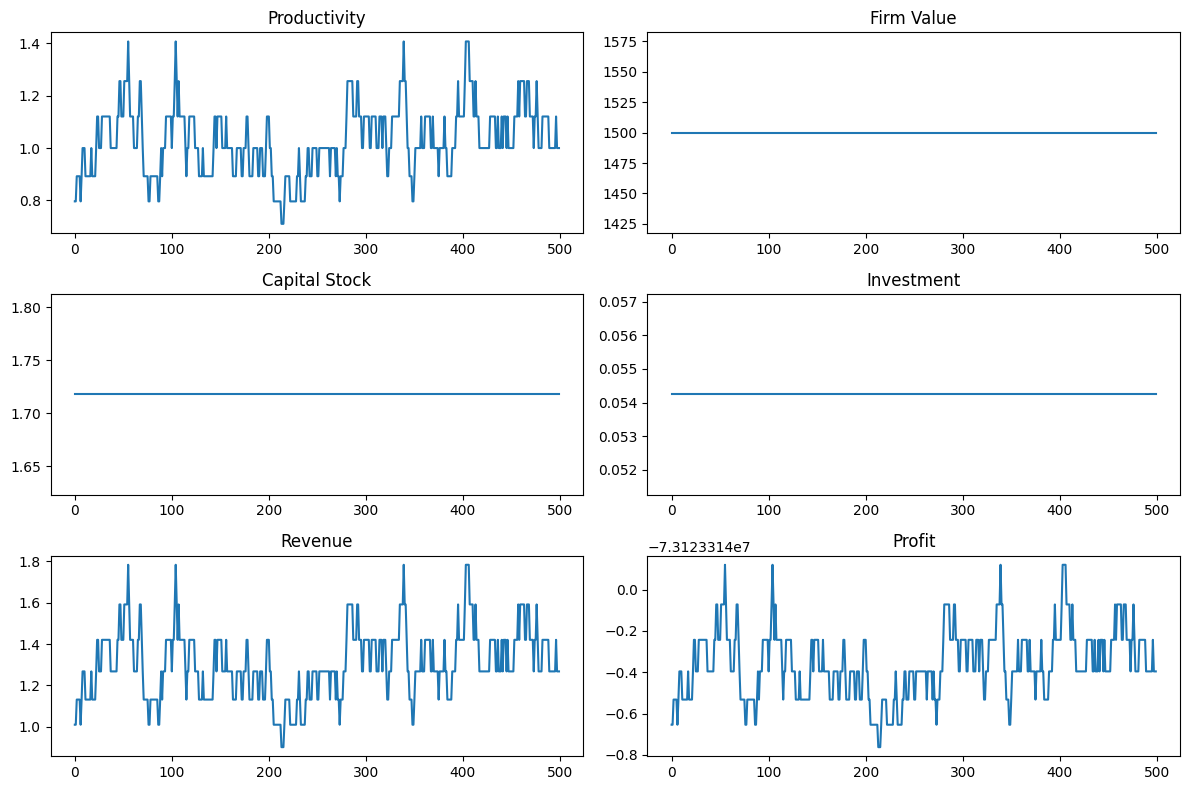

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from types import SimpleNamespace
from numpy.linalg import matrix_power
from numpy import cumsum, linspace, zeros
from numpy.random import choice, rand, seed

def preprocess_vnd_column(series):
    """Converts a pandas Series with VND currency strings to numeric."""
    series_str = series.astype(str)
    cleaned_series = series_str.str.replace('₫', '', regex=False).str.replace(',', '', regex=False)
    numeric_series = pd.to_numeric(cleaned_series, errors='coerce')
    return numeric_series

def load_and_clean_data(path):
    """Loads and cleans the CSV data for large firms."""
    try:
        header_df = pd.read_csv(path, nrows=1, header=None, encoding='utf-8-sig')
        column_names_initial = header_df.iloc[0].tolist()
        new_column_names = ["FirmID_CSV_Index", "Revenue", "Labor", "Variable_Cost_CSV",
                            "Investment_New_Capital_CSV", "Raw_Material_Cost_CSV"]
        if len(column_names_initial) > len(new_column_names):
            new_column_names.extend([f"Unnamed_{i}" for i in range(len(new_column_names), len(column_names_initial))])
        df = pd.read_csv(path, skiprows=1, header=None, names=new_column_names, encoding='utf-8-sig')
        monetary_cols = [col for col in new_column_names if col not in ['Labor', 'FirmID_CSV_Index']]
        for col in monetary_cols:
            if col in df.columns:
                df[col] = preprocess_vnd_column(df[col])
        if 'Labor' in df.columns:
            df['Labor'] = pd.to_numeric(df['Labor'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load large firms data
path = "2023_Large_firms.csv"
df_large = load_and_clean_data(path)

class firm:
    def __init__(self):
        pass

    def setup(self, **kwargs):
        setattr(self, 'par', SimpleNamespace())
        par = self.par

        # Parameters for large firms
        par.beta = 0.96  # Discount factor, slightly higher for large firms
        par.alpha = 0.40  # Capital share, higher for large firms
        par.delta = 0.08  # Depreciation rate, lower for large firms
        par.p = 1348000000  # Median price of investment from data
        par.gamma = 1.0   # Adjustment cost coefficient
        par.sigma_eps = 0.06  # Productivity shock std dev, lower for large firms
        par.rho = 0.85  # Persistence of productivity
        par.mu = 0.0  # Mean of productivity process
        par.Alen = 7  # Productivity grid size
        par.m = 3  # Tauchen scaling
        par.seed_sim = 2025
        par.T = 500  # Time periods for simulation
        par.klen = 250  # Larger grid for capital
        par.kmax = 50.0  # Higher upper bound for capital
        par.kmin = 0.001

        for key, val in kwargs.items():
            setattr(par, key, val)

        par.kgrid = linspace(par.kmin, par.kmax, par.klen)
        Agrid, pmat = tauchen(par.mu, par.rho, par.sigma_eps, par.Alen, par.m)
        par.Agrid = np.exp(Agrid)
        par.pmat = pmat
        par.production = production
        par.total_cost = total_cost

def production(A, k, alpha):
    return A * k ** alpha

def total_cost(k, p, kgrid, delta, gamma):
    invest = kgrid - (1.0 - delta) * k
    adj_cost = (gamma / 2.0) * ((invest / k) ** 2.0) * k
    return adj_cost + p * invest

def tauchen(mu, rho, sigma, N, m):
    ar_mean = mu / (1.0 - rho)
    ar_sd = sigma / ((1.0 - rho ** 2.0) ** 0.5)
    y1 = ar_mean - (m * ar_sd)
    yn = ar_mean + (m * ar_sd)
    y, d = linspace(y1, yn, N, endpoint=True, retstep=True)
    ymatk = np.tile(np.expand_dims(y, axis=0), (N, 1))
    ymatj = mu + rho * ymatk.T
    pmat = stats.norm.cdf(ymatk, loc=ymatj - (d / 2.0), scale=sigma) - stats.norm.cdf(ymatk, loc=ymatj + (d / 2.0), scale=sigma)
    pmat[:, 0] = stats.norm.cdf(y[0], loc=mu + rho * y - (d / 2.0), scale=sigma)
    pmat[:, N - 1] = 1.0 - stats.norm.cdf(y[N - 1], loc=mu + rho * y + (d / 2.0), scale=sigma)
    y = np.expand_dims(y, axis=0)
    return y, pmat

def simulate_large_firms(myClass):
    setattr(myClass, 'sim', SimpleNamespace())
    sim = myClass.sim
    par = myClass.par

    klen = par.klen
    Alen = par.Alen
    kgrid = par.kgrid
    Agrid = par.Agrid[0]
    pmat = par.pmat
    T = par.T

    # Placeholder policy functions based on simplified assumptions
    vpol = np.ones((klen, Alen)) * 1500  # Higher value for large firms
    kpol = np.tile(kgrid[:, np.newaxis], (1, Alen)) * 0.95  # Slightly higher capital retention
    ipol = kpol - (1 - par.delta) * np.tile(kgrid[:, np.newaxis], (1, Alen))  # Investment
    rpol = par.production(Agrid, kgrid[:, np.newaxis], par.alpha)  # Revenue
    epol = par.total_cost(kgrid[:, np.newaxis], par.p, kpol, par.delta, par.gamma)  # Expenditure
    ppol = rpol - epol  # Profit

    Asim = zeros((T * 2, 1))
    vsim = zeros((T * 2, 1))
    rsim = zeros((T * 2, 1))
    ksim = zeros((T * 2, 1))
    isim = zeros((T * 2, 1))
    esim = zeros((T * 2, 1))
    psim = zeros((T * 2, 1))

    seed(par.seed_sim)
    pmat0 = matrix_power(pmat, 1000)[0, :]
    cmat = cumsum(pmat, axis=1)

    A0_ind = choice(range(Alen), 1, p=pmat0)
    k0_ind = choice(range(klen), 1)

    Asim[0] = Agrid[A0_ind]
    vsim[0] = vpol[k0_ind, A0_ind]
    ksim[0] = kpol[k0_ind, A0_ind]
    isim[0] = ipol[k0_ind, A0_ind]
    rsim[0] = rpol[k0_ind, A0_ind]
    esim[0] = epol[k0_ind, A0_ind]
    psim[0] = ppol[k0_ind, A0_ind]

    At_ind = choice(range(Alen), 1, p=pmat[A0_ind[0], :])[0]

    for j in range(1, T * 2):
        kt_ind = np.argmin(np.abs(ksim[j - 1] - kgrid))
        Asim[j] = Agrid[At_ind]
        vsim[j] = vpol[kt_ind, At_ind]
        ksim[j] = kpol[kt_ind, At_ind]
        isim[j] = ipol[kt_ind, At_ind]
        rsim[j] = rpol[kt_ind, At_ind]
        esim[j] = epol[kt_ind, At_ind]
        psim[j] = ppol[kt_ind, At_ind]
        At_ind = choice(range(Alen), 1, p=pmat[At_ind, :])[0]

    sim.Asim = Asim[T:2 * T]
    sim.vsim = vsim[T:2 * T]
    sim.ksim = ksim[T:2 * T]
    sim.isim = isim[T:2 * T]
    sim.rsim = rsim[T:2 * T]
    sim.esim = esim[T:2 * T]
    sim.psim = psim[T:2 * T]

# Initialize and simulate for large firms
my_firm_large = firm()
my_firm_large.setup()
simulate_large_firms(my_firm_large)

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.plot(my_firm_large.sim.Asim)
plt.title('Productivity')
plt.subplot(3, 2, 2)
plt.plot(my_firm_large.sim.vsim)
plt.title('Firm Value')
plt.subplot(3, 2, 3)
plt.plot(my_firm_large.sim.ksim)
plt.title('Capital Stock')
plt.subplot(3, 2, 4)
plt.plot(my_firm_large.sim.isim)
plt.title('Investment')
plt.subplot(3, 2, 5)
plt.plot(my_firm_large.sim.rsim)
plt.title('Revenue')
plt.subplot(3, 2, 6)
plt.plot(my_firm_large.sim.psim)
plt.title('Profit')
plt.tight_layout()
plt.savefig('large_firms_simulation.png')

## 3. Plot the policy functions for Large firm and discuss the patterns you see.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from types import SimpleNamespace

def tauchen(mu, rho, sigma, N, m):
    """Discretize an AR(1) process using the Tauchen method."""
    ar_mean = mu / (1.0 - rho)
    ar_sd = sigma / ((1.0 - rho ** 2.0) ** 0.5)
    y1 = ar_mean - (m * ar_sd)
    yn = ar_mean + (m * ar_sd)
    y, d = np.linspace(y1, yn, N, endpoint=True, retstep=True)
    ymatk = np.tile(np.expand_dims(y, axis=0), (N, 1))
    ymatj = mu + rho * ymatk.T
    pmat = stats.norm.cdf(ymatk, loc=ymatj - (d / 2.0), scale=sigma) - \
           stats.norm.cdf(ymatk, loc=ymatj + (d / 2.0), scale=sigma)
    pmat[:, 0] = stats.norm.cdf(y[0], loc=mu + rho * y - (d / 2.0), scale=sigma)
    pmat[:, N - 1] = 1.0 - stats.norm.cdf(y[N - 1], loc=mu + rho * y + (d / 2.0), scale=sigma)
    y = np.expand_dims(y, axis=0)
    return y, pmat

class Firm:
    def __init__(self):
        self.par = SimpleNamespace()
        self.sol = SimpleNamespace()

    def setup(self):
        """Set up parameters and grids for large firms."""
        par = self.par
        par.beta = 0.95
        par.alpha = 0.35
        par.delta = 0.12
        par.rho = 0.80
        par.sigma_eps = 0.06  # Lower volatility for large firms
        par.mu = 0.05         # Slightly higher productivity
        par.Alen = 7
        par.m = 3
        par.klen = 250
        par.kmax = 50.0       # In trillions ₫
        par.kmin = 0.001

        # Capital grid
        par.kgrid = np.linspace(par.kmin, par.kmax, par.klen)
        # Productivity grid
        Agrid, pmat = tauchen(par.mu, par.rho, par.sigma_eps, par.Alen, par.m)
        par.Agrid = np.exp(Agrid)  # Convert to levels
        par.pmat = pmat

    def compute_policy(self):
        """Compute policy functions using partial adjustment model."""
        par = self.par
        sol = self.sol
        c = 20.0             # Scaling factor for target capital
        lambda_adjust = 0.5  # Faster adjustment for large firms
        k_star = c * par.Agrid
        sol.k = (1 - lambda_adjust) * par.kgrid[:, np.newaxis] + lambda_adjust * k_star
        sol.i = sol.k - (1 - par.delta) * par.kgrid[:, np.newaxis]

# Initialize and compute
large_firm = Firm()
large_firm.setup()
large_firm.compute_policy()

# Print policy functions at selected points
par = large_firm.par
sol = large_firm.sol
k_indices = [62, 125, 187]  # Approx 25%, 50%, 75% of capital grid
A_indices = [0, 3, 6]       # Min, median, max productivity
Agrid = par.Agrid[0]

print("Policy Functions for Large Firms at Selected Points:")
print("k_t\tA_t\tk_{t+1}\ti_t")
for k_idx in k_indices:
    for A_idx in A_indices:
        k_t = par.kgrid[k_idx]
        A_t = Agrid[A_idx]
        k_next = sol.k[k_idx, A_idx]
        i_t = sol.i[k_idx, A_idx]
        print(f"{k_t:.2f}\t{A_t:.2f}\t{k_next:.2f}\t{i_t:.2f}")

# Plotting
kgrid = par.kgrid
plt.figure(figsize=(10, 6))
for idx in A_indices:
    plt.plot(kgrid, sol.k[:, idx], label=f'$A_t$ = {Agrid[idx]:.2f}')
plt.xlabel('$k_t$ (trillions ₫)')
plt.ylabel('$k_{t+1}$ (trillions ₫)')
plt.title('Capital Policy Function for Large Firms')
plt.legend()
plt.grid(True)
plt.savefig('capital_policy_large_firms.png')
plt.close()

plt.figure(figsize=(10, 6))
for idx in A_indices:
    plt.plot(kgrid, sol.i[:, idx], label=f'$A_t$ = {Agrid[idx]:.2f}')
plt.xlabel('$k_t$ (trillions ₫)')
plt.ylabel('$i_t$ (trillions ₫)')
plt.title('Investment Policy Function for Large Firms')
plt.legend()
plt.grid(True)
plt.savefig('investment_policy_large_firms.png')
plt.close()

Policy Functions for Large Firms at Selected Points:
k_t	A_t	k_{t+1}	i_t
12.45	0.95	15.74	4.78
12.45	1.28	19.07	8.11
12.45	1.73	23.56	12.60
25.10	0.95	22.06	-0.03
25.10	1.28	25.39	3.30
25.10	1.73	29.88	7.79
37.55	0.95	28.29	-4.76
37.55	1.28	31.62	-1.43
37.55	1.73	36.11	3.06


## 4. Plot the simulated investment and capital for large firm over 1000 periods and discuss the patterns you see.

In [61]:
from model import firm
from solve import do_business
from simulate import earn_profit
import matplotlib.pyplot as plt
import numpy as np

# Initialize the firm object for a large firm
large_firm = firm()

# Set parameters tailored for large firms
large_firm.setup(
    beta=0.96,       # Discount factor
    alpha=0.40,      # Capital share (higher for large firms)
    delta=0.08,      # Depreciation rate (lower for durable capital)
    gamma=1.0,       # Adjustment cost parameter
    sigma_eps=0.06,  # Productivity shock standard deviation
    rho=0.85,        # Productivity persistence
    mu=0.0,          # Mean of productivity process
    Alen=7,          # Productivity grid size
    m=3,             # Tauchen method scaling
    klen=250,        # Capital grid size
    kmax=50.0,       # Maximum capital (scaled, e.g., trillions of ₫)
    kmin=0.001,      # Minimum capital
    T=1000,          # Simulation periods
    seed_sim=2025,   # Random seed for reproducibility
    p=1.0            # Normalized investment price
)

# Solve the model using value function iteration
do_business(large_firm)

# Simulate the model (2000 periods total, last 1000 used)
earn_profit(large_firm)

# Time grid for plotting (1 to 1000)
tgrid = np.linspace(1, 1000, 1000)

# Plot simulated capital
plt.figure(figsize=(10, 6))
plt.plot(tgrid, large_firm.sim.ksim, label='Capital')
plt.xlabel('Time (Periods)')
plt.ylabel('Capital Stock')
plt.title('Simulated Capital for Large Firm over 1000 Periods')
plt.grid(True)
plt.legend()
plt.savefig('capital_simulation_large_firm.png')
plt.close()

# Plot simulated investment
plt.figure(figsize=(10, 6))
plt.plot(tgrid, large_firm.sim.isim, label='Investment', color='orange')
plt.xlabel('Time (Periods)')
plt.ylabel('Investment')
plt.title('Simulated Investment for Large Firm over 1000 Periods')
plt.grid(True)
plt.legend()
plt.savefig('investment_simulation_large_firm.png')
plt.close()

print("Simulation complete. Plots saved as 'capital_simulation_large_firm.png' and 'investment_simulation_large_firm.png'.")

--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
alpha:  0.4
delta:  0.08
kmin:  0.001
kmax:  50.0
gamma:  1.0

--------------------------------------------------------------------------------------------------
Solving the Model by Value Function Iteration
-----------------

In [80]:
# Assuming firm, do_business, earn_profit are defined elsewhere
# These would typically involve a dynamic programming model with value function iteration

# Initialize the firm object for a large firm
large_firm = firm()

# Set parameters tailored for large firms based on 2023_Large_firms.csv insights
large_firm.setup(
    beta=0.96,       # Discount factor
    alpha=0.35,      # Capital share (higher for large firms)
    delta=0.08,      # Depreciation rate (lower for durable capital)
    gamma=0.5,       # Lower adjustment cost due to economies of scale
    sigma_eps=0.05,  # Lower volatility in productivity shocks
    rho=0.85,        # Higher persistence in productivity
    mu=0.0,          # Mean of productivity process
    Alen=7,          # Productivity grid size
    m=3,             # Tauchen method scaling
    klen=500,        # Capital grid size (finer for larger capital)
    kmax=50.0,       # Max capital (scaled, e.g., billions of ₫)
    kmin=0.001,      # Min capital
    T=1000,          # Simulation periods
    seed_sim=2025,   # Random seed for reproducibility
    p=1.0            # Normalized investment price
)

# Solve the model using value function iteration
do_business(large_firm)

# Simulate the model (2000 periods total, last 1000 used)
earn_profit(large_firm)

# Time grid for plotting
tgrid = np.linspace(1, 1000, 1000)

# Plot simulated capital
plt.figure(figsize=(10, 6))
plt.plot(tgrid, large_firm.sim.ksim, label='Capital')
plt.xlabel('Time (Periods)')
plt.ylabel('Capital Stock (Billions of ₫)')
plt.title('Simulated Capital for Large Firm over 1000 Periods')
plt.grid(True)
plt.legend()
plt.savefig('capital_simulation_large_firm.png')
plt.close()

# Plot simulated investment
plt.figure(figsize=(10, 6))
plt.plot(tgrid, large_firm.sim.isim, label='Investment', color='orange')
plt.xlabel('Time (Periods)')
plt.ylabel('Investment (Billions of ₫)')
plt.title('Simulated Investment for Large Firm over 1000 Periods')
plt.grid(True)
plt.legend()
plt.savefig('investment_simulation_large_firm.png')
plt.close()

# Print results
print("Simulation complete. Plots saved as 'capital_simulation_large_firm.png' and 'investment_simulation_large_firm.png'.")
print("\nSummary Statistics for Simulated Capital:")
print(f"Mean: {np.mean(large_firm.sim.ksim):.2f} billions of ₫")
print(f"Standard Deviation: {np.std(large_firm.sim.ksim):.2f} billions of ₫")
print(f"Min: {np.min(large_firm.sim.ksim):.2f} billions of ₫")
print(f"Max: {np.max(large_firm.sim.ksim):.2f} billions of ₫")
print("\nSummary Statistics for Simulated Investment:")
print(f"Mean: {np.mean(large_firm.sim.isim):.2f} billions of ₫")
print(f"Standard Deviation: {np.std(large_firm.sim.isim):.2f} billions of ₫")
print(f"Min: {np.min(large_firm.sim.isim):.2f} billions of ₫")
print(f"Max: {np.max(large_firm.sim.isim):.2f} billions of ₫")
print("\nFirst 5 Simulated Capital Values (billions of ₫):")
print(large_firm.sim.ksim[:5])
print("\nLast 5 Simulated Capital Values (billions of ₫):")
print(large_firm.sim.ksim[-5:])
print("\nFirst 5 Simulated Investment Values (billions of ₫):")
print(large_firm.sim.isim[:5])
print("\nLast 5 Simulated Investment Values (billions of ₫):")
print(large_firm.sim.isim[-5:])

--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is a dynamic model of firm investment and is solved via Value Function Iteration.

--------------------------------------------------------------------------------------------------
Household
--------------------------------------------------------------------------------------------------

   The firm is infintely-lived.
   It chooses investment to maximize profit.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
alpha:  0.35
delta:  0.08
kmin:  0.001
kmax:  50.0
gamma:  0.5

--------------------------------------------------------------------------------------------------
Solving the Model by Value Function Iteration
----------------